# Hypothetical Allocation 

- Apple, Home Depot, Honeywell, Palantir, Crowdstrike

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import matplotlib as mpl
import seaborn as sns
import scipy as scs
import math
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.linear_model import QuantileRegressor
from sklearn.decomposition import PCA

from scipy.optimize import lsq_linear
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [36]:
tickers = 'AAPL MNST'
rf = pd.DataFrame(yf.download('^IRX',interval = '1mo')['Adj Close']).dropna()
rf.columns = ['1M Treasury']
rf['1M Treasury'] *= 10**-2
rf['1M Treasury'] /= 3
assets = pd.DataFrame(yf.download(tickers, interval = '1mo')['Adj Close']).dropna()

assets.columns = ['Apple','Monster']
rets = assets.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


In [37]:
rets = rets.join(rf, how = 'inner')

In [38]:
rets.head()

,Apple,Monster,1M Treasury
Date,,,
1986-02-01,0.081075,0.142857,0.023400
1986-03-01,0.130001,0.249999,0.021133
1986-04-01,0.070800,0.000000,0.020333
1986-05-01,0.223140,0.000000,0.021000
1986-06-01,-0.030409,0.000000,0.019867


<AxesSubplot:title={'center':'Growth of One Dollar Invested'}, xlabel='Date'>

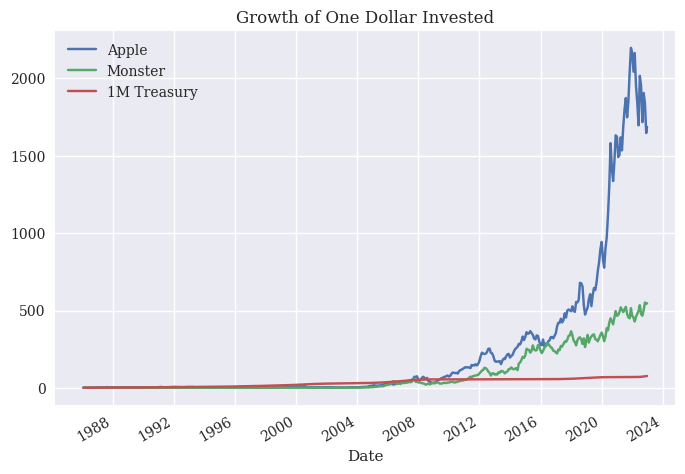

In [39]:
((1+rets).cumprod()).plot(title='Growth of One Dollar Invested')

In [40]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [44]:
performance_summary(rets)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Apple,0.296510,0.428675,0.691691,-0.157501,1.531374,-0.156476,-0.247576,-0.796380,1991-03-01,1997-12-01,1999-08-01
Monster,0.330682,0.592894,0.557742,1.572179,7.593614,-0.187510,-0.282981,-0.946222,1986-03-01,1995-12-01,2004-03-01
1M Treasury,0.118183,0.028528,4.142764,0.311066,-1.126604,0.000061,0.000029,0.000000,1986-02-01,1986-02-01,1986-02-01


In [46]:
rets_excess = rets.subtract(rets['1M Treasury'], axis = 0).drop(columns = ['1M Treasury'])

In [47]:
performance_summary(rets_excess)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Apple,0.178327,0.429995,0.414720,-0.232740,1.534991,-0.171765,-0.262088,-0.975348,1987-09-01,2003-03-01,2012-02-01
Monster,0.212499,0.594616,0.357371,1.479114,7.321383,-0.203362,-0.304043,-0.994600,1986-03-01,1996-03-01,2012-01-01


In [ ]:
Ntime, Nassets = rets_excess.shape
y = np.ones((Ntime,1))
x = rets_excess

beta = LinearRegression(fit_intercept=False, positive = True).fit(x,y).coef_.transpose()

beta /= beta.sum()

beta
beta = pd.DataFrame(beta, columns = ['Weight'], index = [rets_excess.columns])
beta
beta_1 = np.matrix(beta)

In [ ]:
beta

,Weight
Apple,0.630029
Monster,0.369971


# Performance of This Portfolio

In [ ]:
performance_port = rets_excess@np.array(beta)
performance_port.columns = ['Pat Helle Portfolio']

In [ ]:
performance_summary(performance_port)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Pat Helle Portfolio,0.19097,0.376174,0.507663,0.11906,1.694556,-0.157093,-0.211332,-0.933317,1987-08-01,1997-06-01,2005-09-01


<AxesSubplot:title={'center':'Pat Helle Growth of $1 Dollar'}, xlabel='Date'>

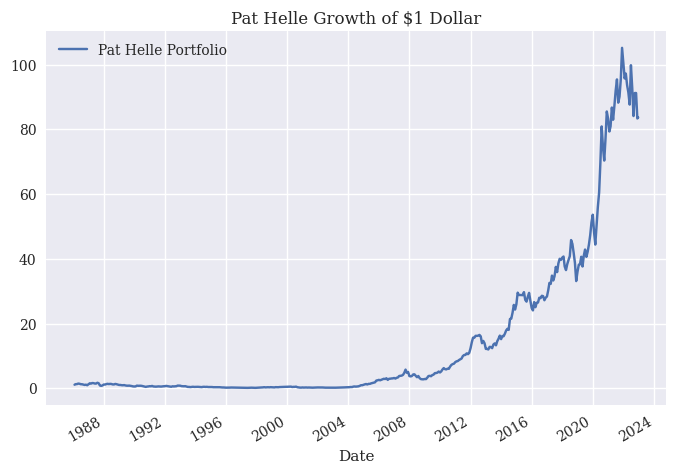

In [ ]:
cum_performance = ((1+performance_port).cumprod())
cum_performance.plot(title = 'Pat Helle Growth of $1 Dollar')

In [ ]:
cum_performance.tail(1)

,Pat Helle Portfolio
Date,
2022-12-21,83.716024


- Gross return of 1053%. 
- If you put 20,000 dollars at the beginning it would be worth $230,600

In [ ]:
coke_cola = pd.DataFrame(yf.download('KO')['Adj Close']).pct_change().dropna()
performance_summary(coke_cola)

[*********************100%***********************]  1 of 1 completed


,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Adj Close,0.006874,0.050484,0.136165,-0.064472,12.7307,-0.020932,-0.032078,-0.682314,1973-03-14,1974-10-04,1982-11-04


<AxesSubplot:xlabel='Date'>

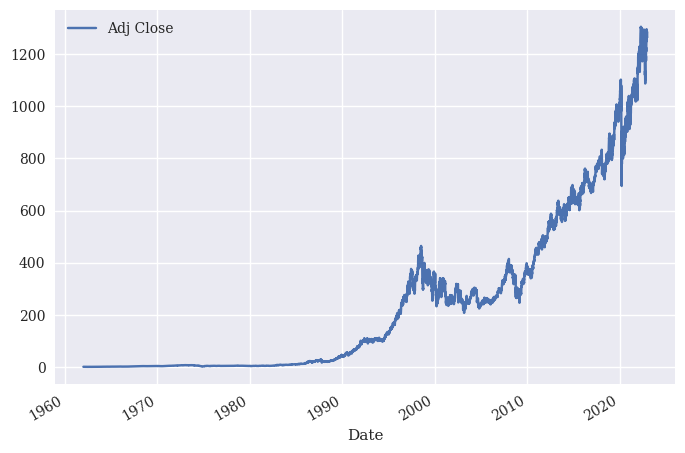

In [ ]:
cum_return_coke = ((1+coke_cola).cumprod())
cum_return_coke.plot()

In [ ]:
cum_return_coke.tail()

,Adj Close
Date,
2022-12-15,1270.748387
2022-12-16,1263.499612
2022-12-19,1265.311806
2022-12-20,1264.305049
2022-12-21,1284.641821
